In [75]:
pip install wfdb

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [77]:
import os

In [78]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [79]:
path='/kaggle/input/ecg-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [80]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [81]:
Y.scp_codes.shape

(21799,)

In [82]:
X = load_raw_data(Y, sampling_rate, path)

In [83]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [84]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [85]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [86]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [87]:
X_train.shape

(19601, 1000, 12)

In [88]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [89]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [90]:
np.unique(y_train).shape[0]

22

In [91]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [92]:
y_train_encoded.shape

(19601, 5)

In [93]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [94]:
type(y_train_encoded)

pandas.core.frame.DataFrame

In [95]:
y_train_encoded['final_output']=y_train_encoded.apply(lambda x:''.join(x.astype(str)),axis=1)

In [96]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,00010
1,0,0,0,1,0,00010
2,0,0,0,1,0,00010
3,0,0,0,1,0,00010
4,0,0,0,1,0,00010


In [97]:
y_train_encoded['final_output'].nunique()

22

In [98]:
y_train_encoded['final_output'].unique()

array(['00010', '00100', '00000', '00001', '01000', '10000', '00101',
       '11000', '10100', '10001', '01100', '01101', '01001', '10101',
       '10010', '11101', '11001', '00011', '11100', '10011', '01010',
       '11110'], dtype=object)

In [99]:
def adjust_classes(y_train):
    var=y_train
    if var == '00010':
        var=0
    elif var == '00100':
        var =1
    elif var== '00000':
        var=2
    elif var=='00001':
        var =3
    elif var =='01000':
        var=4
    elif var=='10000':
        var =5
    elif var =='00101':
        var =6
    elif var =='11000':
        var=7
    elif var =='10100':
        var=8
    elif var=='10001':
        var =9
    elif var =='01100':
        var =10
    elif var =='01101':
        var =11
    elif var=='01001':
        var=21
    elif var =='10101':
        var=12
    elif var =='10010':
        var=13
    elif var=='11101':
        var=14
    elif var=='11001':
        var=15
    elif var =='00011':
        var=16
    elif var=='11100':
        var=17
    elif var=='10011':
        var=18
    elif var =='01010':
        var=19
    elif var=='11110':
        var=20
    return var

In [100]:
y_train_encoded['final_output']=y_train_encoded['final_output'].apply(adjust_classes)

In [101]:
y_train_encoded

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
19596,0,0,0,0,1,3
19597,0,0,0,1,0,0
19598,0,0,0,0,1,3
19599,0,0,0,1,0,0


In [102]:
y_train_encoded['final_output'].value_counts()

final_output
0     8157
1     2276
3     2158
5     1524
8     1164
21     708
6      538
4      479
9      433
2      371
13     362
11     320
7      273
12     202
15     186
10     166
14     140
17     112
16      24
18       5
19       2
20       1
Name: count, dtype: int64

In [103]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [104]:
x_train_normalization=X_train.reshape(-1,1000*12)

In [105]:
x_train=scaler.fit_transform(x_train_normalization)
x_train_normalized=x_train.reshape(19601,1000,12)

In [106]:
x_train_normalized[0].shape

(1000, 12)

In [107]:
import numpy as np
from scipy.signal import resample

# Assuming your data is a 2D NumPy array with shape (1000, 12) and 500 Hz frequency
# Replace this with your actual data
ecg_data = x_train_normalized[0]# Example data

# Original and target frequencies
original_frequency = 500  # 500 Hz
target_frequency = 125  # 125 Hz

# Number of time points after downsampling
num_time_points_original = ecg_data.shape[0]
num_time_points_target = int(num_time_points_original * target_frequency / original_frequency)

# Resample each lead
downsampled_ecg_data = np.zeros((num_time_points_target, ecg_data.shape[1]))
for lead_index in range(ecg_data.shape[1]):
    downsampled_ecg_data[:, lead_index] = resample(ecg_data[:, lead_index], num_time_points_target)

print("Downsampled ECG data shape:", downsampled_ecg_data.shape)


Downsampled ECG data shape: (250, 12)


In [113]:
import numpy as np
from scipy.signal import resample

# Original and target frequencies
original_frequency = 500  # 500 Hz
target_frequency = 125  # 125 Hz

# Calculate the target number of time points
num_time_points_original = x_train_normalized.shape[1]
num_time_points_target = int(num_time_points_original * target_frequency / original_frequency)

# Prepare a new array to hold the downsampled data
downsampled_x_train = np.zeros((x_train_normalized.shape[0], num_time_points_target, x_train_normalized.shape[2]))

# Resample each sample and each lead
for sample_index in range(x_train_normalized.shape[0]):
    for lead_index in range(x_train_normalized.shape[2]):
        downsampled_x_train[sample_index, :, lead_index] = resample(x_train_normalized[sample_index, :, lead_index], num_time_points_target)

print("Downsampled x_train_normalized shape:", downsampled_x_train.shape)


Downsampled x_train_normalized shape: (19601, 250, 12)


In [114]:
x_train=downsampled_x_train[:,:,1:2]
x_train.shape

(19601, 250, 1)

In [117]:
y_train_encoded.shape

(19601, 6)

In [125]:
indices_0 = np.where(y_train_encoded['NORM'] == 0)[0] 
indices_1 = np.where(y_train_encoded['NORM'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=x_train[selected_indices_0]
x_train_norm1=x_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)

In [126]:
len(selected_indices_0)

4000

In [127]:
len(selected_indices_1)

4000

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 248, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 248, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 124, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 124, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 122, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 122, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 59, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 59, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6147 - loss: 0.8556 - val_accuracy: 0.9056 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7622 - loss: 0.4902 - val_accuracy: 0.9369 - val_loss: 0.3005 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7753 - loss: 0.4539 - val_accuracy: 0.9469 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7975 - loss: 0.4349 - val_accuracy: 0.8844 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8095 - loss: 0.4259 - val_accuracy: 0.8694 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7981 - loss: 0.4299 - val_accuracy: 0.9237 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8057 - 

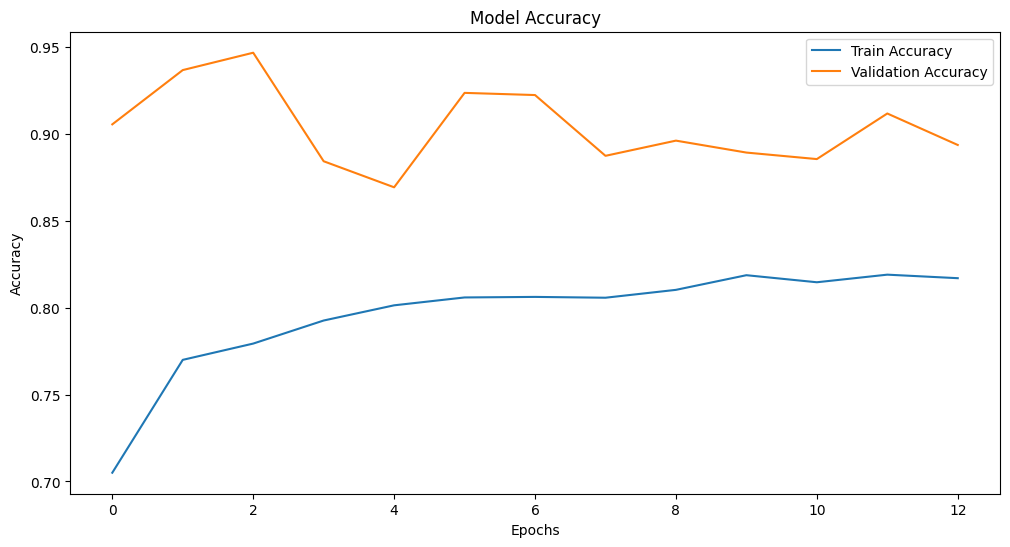

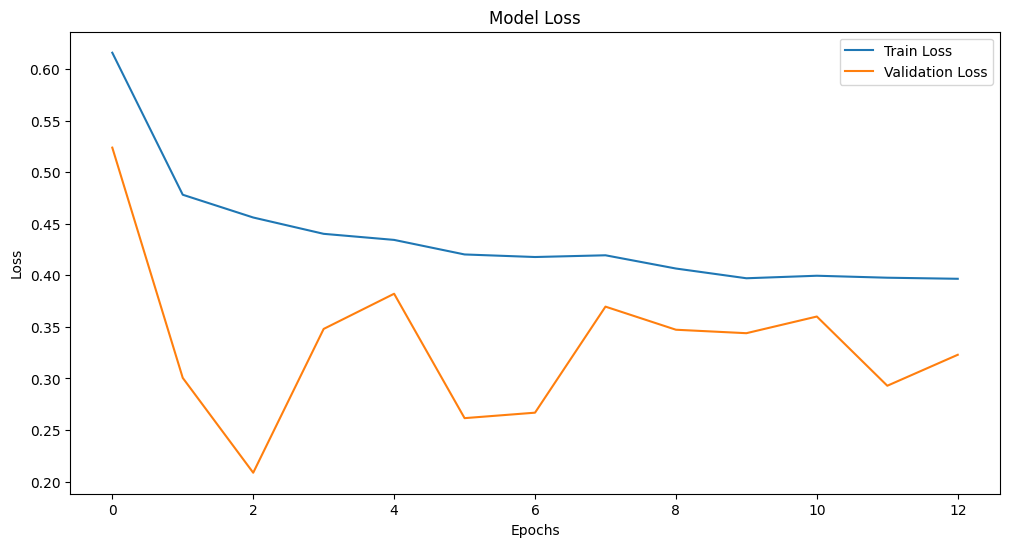

In [128]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train is your downsampled data with shape (num_samples, 250, 1)
# Ensure x_train has the shape (19601, 250, 1) as per your previous downsampling

# Reshape x_train to match input shape if necessary (already assumed as (19601, 250, 1))
x_train = x_train.reshape(-1, 250, 1)

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # Adjust based on your class count

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 248, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 248, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 124, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 124, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 122, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 122, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 59, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 59, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4865 - loss: 3.7574 - val_accuracy: 0.9550 - val_loss: 3.4708 - learning_rate: 1.0000e-04
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6576 - loss: 2.9921 - val_accuracy: 0.9394 - val_loss: 2.9289 - learning_rate: 1.0000e-04
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7061 - loss: 2.6422 - val_accuracy: 0.9362 - val_loss: 2.5439 - learning_rate: 1.0000e-04
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7448 - loss: 2.3644 - val_accuracy: 0.9325 - val_loss: 2.2164 - learning_rate: 1.0000e-04
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7561 - loss: 2.1526 - val_accuracy: 0.9362 - val_loss: 1.9713 - learning_rate: 1.0000e-04
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7476 - loss: 1.9810 - val_accuracy: 0.9275 - val_loss: 1.7993 - learning_rate: 1.0000e-04
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/s

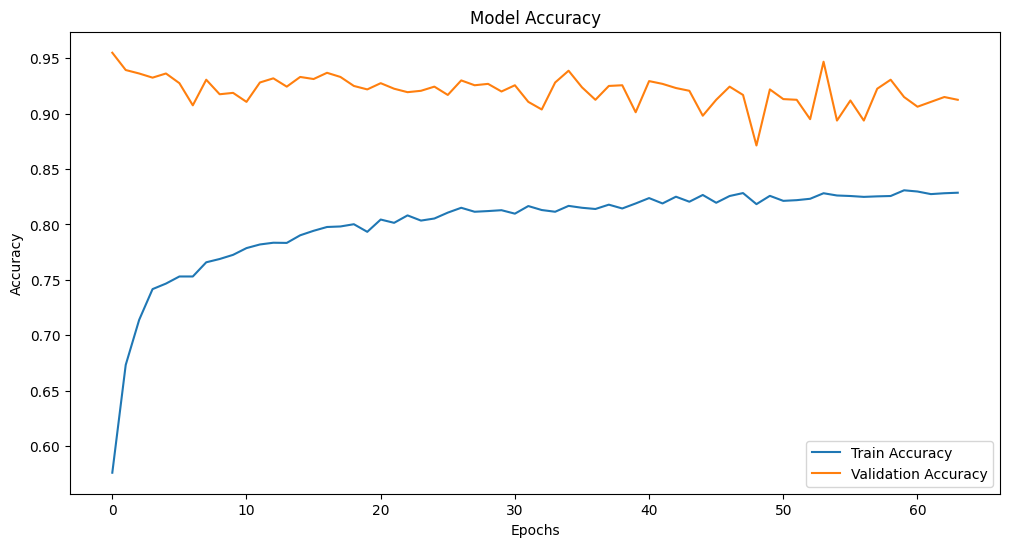

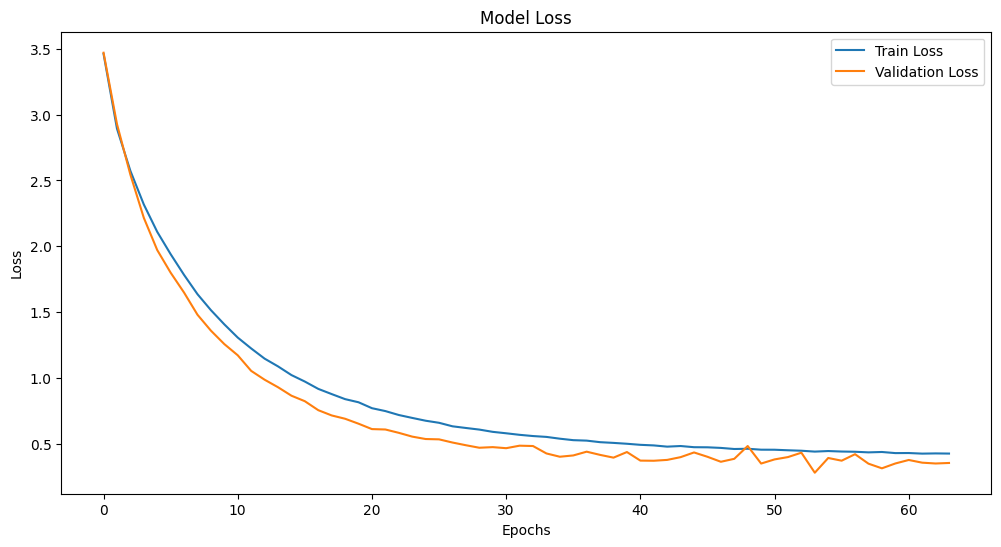

In [129]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Assuming x_train is your downsampled data with shape (num_samples, 250, 1)
# Ensure x_train has the shape (19601, 250, 1) as per your previous downsampling
x_train = x_train.reshape(-1, 250, 1)

# Define the model
model = Sequential()

# First convolutional layer with L2 regularization
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(250, 1), 
                 kernel_regularizer=l2(0.01)))  # Adding L2 regularization
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer with L2 regularization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer with L2 regularization
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', 
                 kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # Adjust based on your class count

# Compile the model with Nadam optimizer
model.compile(optimizer=Nadam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()
